In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv("database_new.csv", delimiter=";", index_col=0, names=['id', 'user_id', 'problem_id', 'category', 'result'])

In [3]:
df.head()

,user_id,problem_id,category,result
id,,,,
1,7661,10332,26,0
2,7661,4504,74,0
3,7661,620,115,1
4,7661,4170,76,0
5,7661,4359,24,1


In [4]:
df.shape

(27864481, 4)

In [5]:
df.user_id.unique().shape

(88905,)

In [6]:
df.problem_id.unique().shape

(11133,)

## сколько заданий решают школьники

In [7]:
count_by_user = df.groupby("user_id").agg({"problem_id":"count"}).rename({"problem_id":"count_solved_tasks"}, axis=1)
count_by_user = count_by_user[count_by_user.count_solved_tasks < 5000]

In [8]:
count_by_user.head()

,count_solved_tasks
user_id,
1,137
2,96
3,64
4,87
6,458


<AxesSubplot:ylabel='Count'>

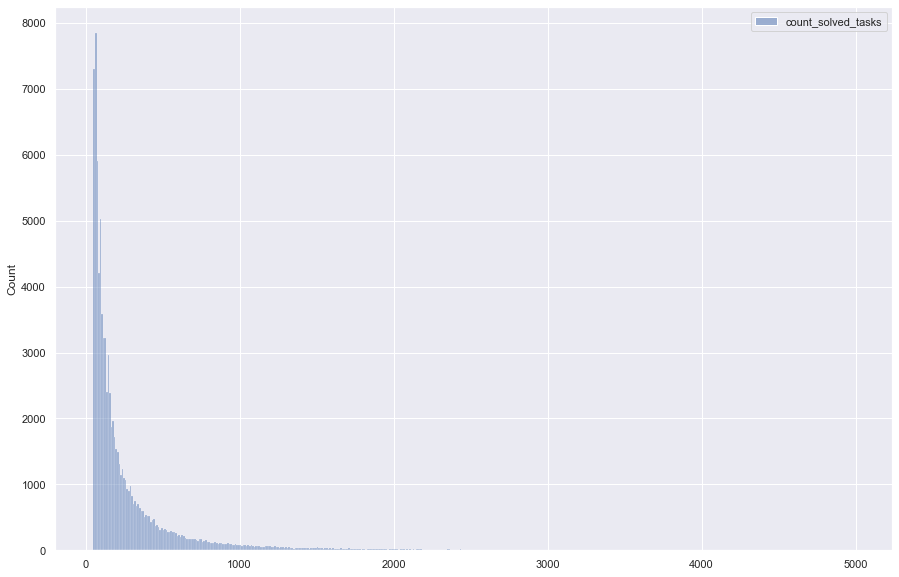

In [9]:
sns.set_theme(style="darkgrid")
plt.figure(figsize=(15, 10))
sns.histplot(count_by_user)

## самые популярные задания

In [10]:
df_problems_grouped = pd.DataFrame(df.groupby("problem_id").agg({"problem_id":"count"}).rename({"problem_id":"count_solutions"}, axis=1).sort_values("count_solutions", ascending=False))
MIN_COUNT_SOLUTIONS_ON_TASK = 750
saldom_problems = df_problems_grouped[df_problems_grouped.count_solutions < MIN_COUNT_SOLUTIONS_ON_TASK]
df_count_solutions = df_problems_grouped[df_problems_grouped.count_solutions > MIN_COUNT_SOLUTIONS_ON_TASK]

## задания которые будут использоваться

In [11]:
df_count_solutions.count_solutions.sum()

27221513

In [12]:
df_count_solutions.shape

(2829, 1)

## задания, которые не будут использоваться

In [13]:
saldom_problems.shape

(8304, 1)

In [14]:
saldom_problems.count_solutions.sum()

642968

## распределение числа решений задач

<AxesSubplot:xlabel='Count solutions for tasks', ylabel='Count'>

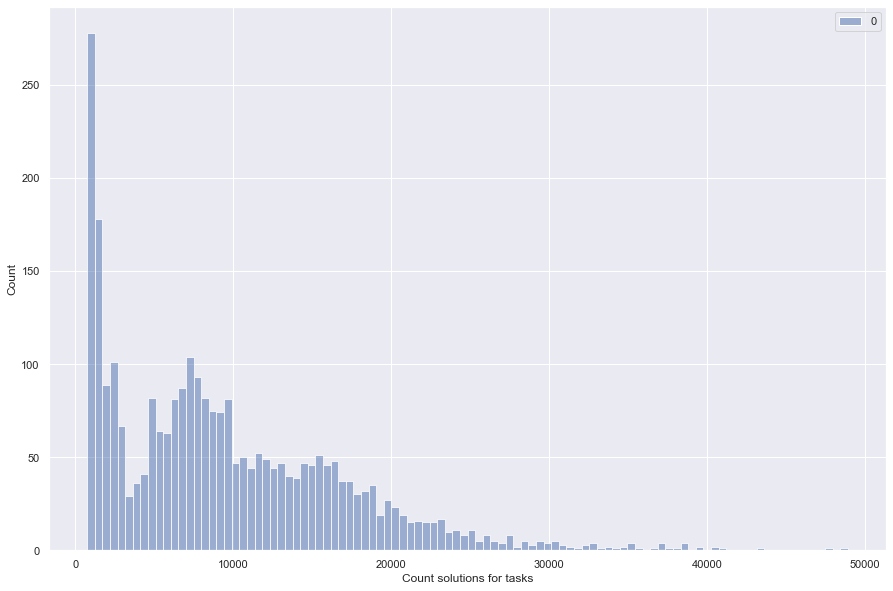

In [15]:
sns.set_theme(style="darkgrid")
plt.figure(figsize=(15, 10))
plt.ylabel("Count")
plt.xlabel("Count solutions for tasks")

sns.histplot(df_count_solutions.values, bins=100)

In [16]:
len(list(df_count_solutions.index.unique()))

2829

## задания которые будут использоваться

In [17]:
available_tasks = df_count_solutions.index.values
available_tasks.shape

(2829,)

In [18]:
available_tasks = set(available_tasks)

In [19]:
# df["true_result"] = df.apply(lambda x: x.problem_id in available_tasks and x.result == dct_problems_to_max_score[x.problem_id], axis=1)

In [20]:
df_grouped_by_problems = df.groupby("problem_id")

## определим максимальные баллы за каждое задание

In [21]:
## максимальные баллы за каждое задание
dct_problems_to_max_score = dict()

for task_id in tqdm(available_tasks):
    tmp = df_grouped_by_problems.get_group(task_id)
    task_result_max = tmp.result.max()
    if tmp.result.value_counts()[task_result_max] < 10:
        task_result_max = 1
    dct_problems_to_max_score[task_id] = task_result_max


100%|██████████| 2829/2829 [00:04<00:00, 642.04it/s] 


## процент правильности решений

In [94]:
results_tasks = []

for task in tqdm(list(available_tasks)[:500]):
    group = df_grouped_by_problems.get_group(task)
    group["true_result"] = group.apply(lambda x: x.result == dct_problems_to_max_score[x.problem_id], axis=1)
    results_tasks.append(group.true_result.mean())


  5%|▌         | 27/500 [00:04<01:20,  5.86it/s]


KeyboardInterrupt: 

Text(0.5, 1.0, 'Распределение процента решенных заданий ')

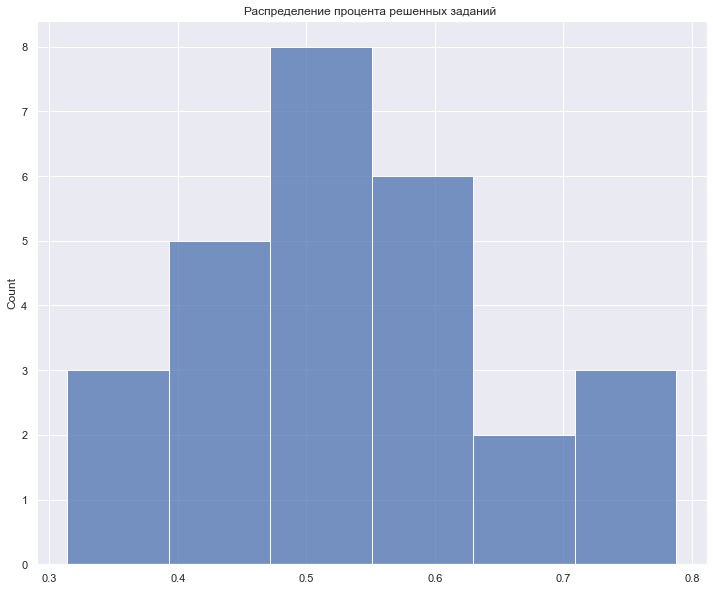

In [95]:
plt.figure(figsize=(12, 10))
sns.histplot(results_tasks)
plt.title("Распределение процента решенных заданий ")

## определим множество людей которые решали только те задачи которые мы рассматриваем

In [22]:
df_grouped_by_user = df.groupby("user_id")

In [35]:
all_count = 0
count_errors = 0
count_errors_2 = 0
count_errors_3 = 0
available_users = set()

procents_correct_solutions_for_user = []

for user in tqdm(df.user_id.unique()):
    tmp = df_grouped_by_user.get_group(user)

    procent_correct_solutions = (tmp.result > 0).mean()
    procents_correct_solutions_for_user.append(procent_correct_solutions)

    if procent_correct_solutions < 0.6:
        count_errors_3 += 1
        continue

    count_solved_tasks = tmp.shape[0]
    all_count += 1

    if count_solved_tasks < 100 or count_solved_tasks > 10000:
        count_errors_2 += 1
        continue

    if tmp.problem_id.isin(available_tasks).all():
        # if not all([task in available_tasks for task in tmp.problem_id.values]):
        available_users.add(user)
    else:
        count_errors += 1

100%|██████████| 88905/88905 [00:41<00:00, 2168.40it/s]


In [36]:
print("Кол-во ошибок: ", count_errors + count_errors_2)
print("Кол-во ошибок по проценту правильных решений: ", count_errors_3)

Кол-во ошибок:  32633
Кол-во ошибок по проценту правильных решений:  31145


In [37]:
len(df.user_id.unique()) - count_errors - count_errors_2 - count_errors_3

25127

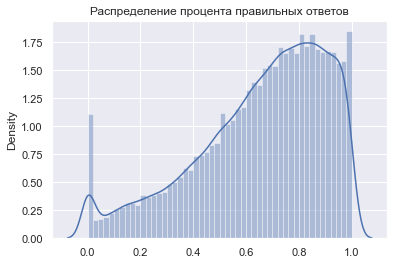

In [40]:
sns.distplot(procents_correct_solutions_for_user).set_title("Распределение процента правильных ответов")
None

In [41]:
count_moves = 0
counts_solved_tasks = []

for user in tqdm(available_users):
    count_solved_tasks =  df_grouped_by_user.get_group(user).shape[0]
    count_moves += count_solved_tasks
    counts_solved_tasks.append(count_solved_tasks)

100%|██████████| 25127/25127 [00:01<00:00, 13518.24it/s]


In [42]:
count_moves

8427903

## распределение кол-ва решений школьников для отфильтрованного датасета

<AxesSubplot:xlabel='Count solved tasks', ylabel='Count students with this count of solved tasks'>

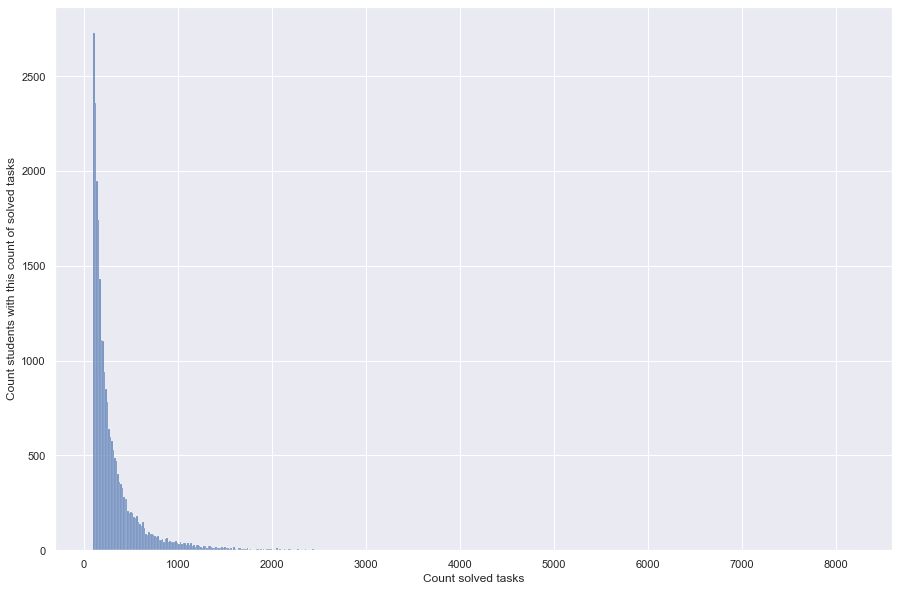

In [43]:
sns.set_theme(style="darkgrid")
plt.figure(figsize=(15, 10))
plt.ylabel("Count students with this count of solved tasks")
plt.xlabel("Count solved tasks")

sns.histplot(counts_solved_tasks)

## главная обработка данных

необходимо привести в формат
[номер_задачи_1, номер_задачи_2, ..., номер_задачи_n]
[правильность_ответа_1, правильность_ответа_2, ...? правильность_ответа_n]
для каждого ученика (из 20к примерно)

In [44]:
len(dct_problems_to_max_score)

2829

In [150]:
def zero_runs(a):
    iszero = np.concatenate(([0], np.equal(a, 0).view(np.int8), [0]))
    absdiff = np.abs(np.diff(iszero))
    ranges = np.where(absdiff == 1)[0].reshape(-1, 2)
    max_len = -1
    for i, j in ranges.tolist():
        max_len = max(max_len, j - i)
    return max_len

In [151]:
zero_runs([11, 1, 1, 1, 0, 0, 0, 1, 1, 2, 0])

3

In [161]:
all_histories = []
deltas = []
zero_runs_value = []

for user in tqdm(available_users):
    user_history = df_grouped_by_user.get_group(user)


    problems_history = user_history.problem_id.values
    correctness_history = []
    last_right_answer_ind = None
    first_right_answer = None

    for ind, score in enumerate(user_history.result.values):
        is_correct = score == dct_problems_to_max_score[problems_history[ind]]

        correctness_history.append(is_correct)

        if first_right_answer is None and is_correct:
            first_right_answer = ind

        if score == dct_problems_to_max_score[problems_history[ind]]:
            last_right_answer_ind = ind

    zero_runs_value.append(zero_runs(correctness_history))
    if zero_runs(correctness_history) > 9:
        continue

    correctness_history = correctness_history[first_right_answer:last_right_answer_ind]
    center = len(correctness_history) // 2

    second_part_percent = sum(correctness_history[center:]) / center
    first_part_percent = sum(correctness_history[:center]) / center

    deltas.append(second_part_percent - first_part_percent)
    all_histories.append((problems_history, correctness_history))

100%|██████████| 25127/25127 [00:15<00:00, 1655.43it/s]


In [153]:
np.mean([len(history) for i, history in all_histories])

221.70256825543728

In [154]:
print(list(map(int, all_histories[856][1])))

[1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1]


Text(0.5, 1.0, 'Распределение длины самого длиного промежутка из нулей')

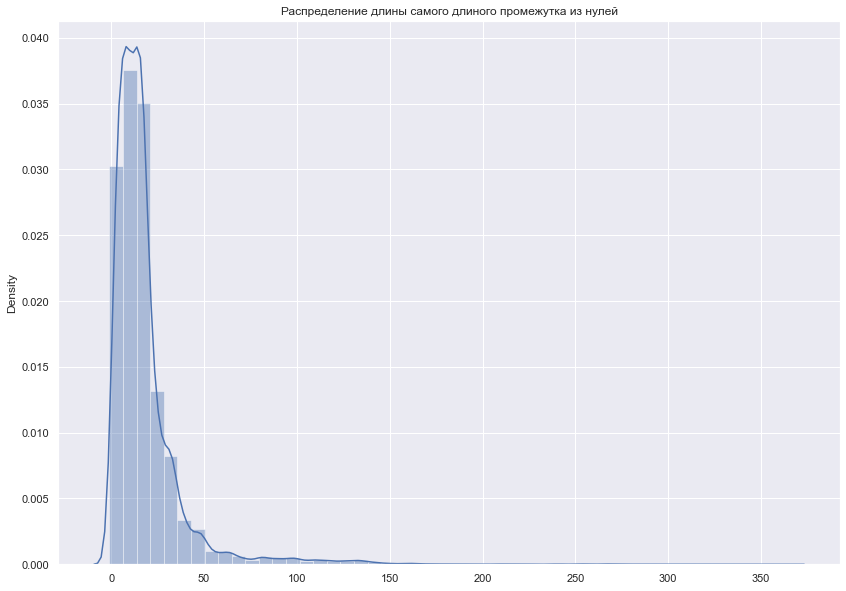

In [163]:
plt.figure(figsize=(14, 10))
sns.distplot(zero_runs_value).set_title("Распределение длины самого длиного промежутка из нулей")

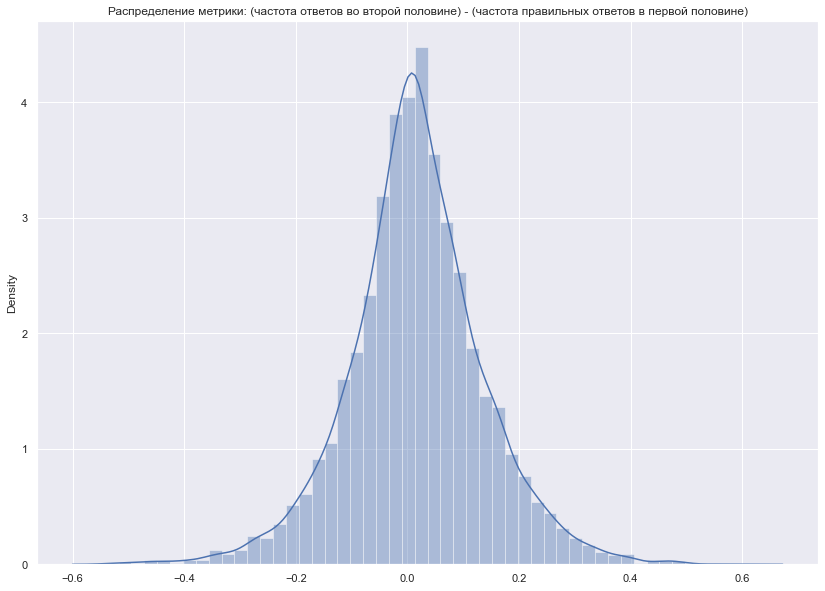

In [158]:
plt.figure(figsize=(14, 10))
sns.distplot(deltas).set_title("Распределение метрики: (частота ответов во второй половине) - (частота правильных ответов в первой половине)")
None

In [164]:
print(np.mean(deltas))
print(np.std(deltas))

0.015716194700670028
0.12122203239560382


In [110]:
df[df.user_id == 7661]

,user_id,problem_id,category,result
id,,,,
1,7661,10332,26,0
2,7661,4504,74,0
3,7661,620,115,1
4,7661,4170,76,0
5,7661,4359,24,1
...,...,...,...,...
27739862,7661,10150,158,2
27739864,7661,10447,158,2
27739865,7661,29253,158,2


In [109]:
correctness_history

[False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 False,
 True,
 True,
 False,
 True,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 True,
 True,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 True,
 True,
 True,
 True,
 False,
 True,
 True,
 True,
 True,
 False,
 True,
 True,
 True,
 False,
 True,
 True,
 True,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False]

In [36]:
len(set(all_histories[0][0]))

137

In [37]:
all_tasks_in_dataset = set()

for i in tqdm(all_histories):
    for j in i[0]:
        all_tasks_in_dataset.add(j)

100%|██████████| 40359/40359 [00:02<00:00, 18081.17it/s]


In [38]:
len(all_tasks_in_dataset)

2829

In [39]:
set([type(i) for i in all_tasks_in_dataset])

{numpy.int64}

In [40]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(list(all_tasks_in_dataset))

LabelEncoder()

In [42]:
import pickle
with open("new_label_encoder.pkl", "wb") as f:
    pickle.dump(le, f)

In [43]:
le.classes_

array([    8,    22,    23, ..., 52204, 52205, 52206], dtype=int64)

In [44]:
for ind, i in enumerate(tqdm(all_histories)):
    all_histories[ind] = (le.transform(all_histories[ind][0]), all_histories[ind][1])

100%|██████████| 40359/40359 [00:03<00:00, 11956.90it/s]


In [45]:
all_histories_filtered_by_count_right_answers = []

for ind, i in enumerate(tqdm(all_histories)):
    if sum(i[1]) / len(i[1]) > 0.4:
        all_histories_filtered_by_count_right_answers.append(all_histories[ind])

100%|██████████| 40359/40359 [00:20<00:00, 2010.44it/s]


In [46]:
len(all_histories_filtered_by_count_right_answers)

22427

In [47]:
all_sum_count = 0

for i in all_histories_filtered_by_count_right_answers:
    all_sum_count += len(i[1])

In [48]:
all_sum_count

7832325

## сохраняемся

In [49]:
import pickle

with open("proccesed_dataset_new.pickle", "wb") as f:
    pickle.dump(all_histories_filtered_by_count_right_answers, f)